NOTEBOOK 03: DIMENSIONALITY REDUCTION

Mục tiêu: Áp dụng PCA và t-SNE để giảm chiều dữ liệu và trực quan hóa


Import Libraries và Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json
import time

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

# Load data
df = pd.read_csv('../data/processed/data_normalized.csv')
print(f"✓ Data loaded: {df.shape}")

# Load metadata
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

target_col = metadata['target_column']
print(f"✓ Target variable: {target_col}")

# Separate features and target
y = df[target_col].values
X = df.drop(target_col, axis=1).values
feature_names = df.drop(target_col, axis=1).columns.tolist()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_names)}")

✓ Libraries imported successfully!
✓ Data loaded: (1470, 48)
✓ Target variable: JobSatisfaction

Features shape: (1470, 47)
Target shape: (1470,)
Number of features: 47


2.Determine Optimal Number of Components

Components needed for 80% variance: 24
Components needed for 85% variance: 26
Components needed for 90% variance: 29
Components needed for 95% variance: 32
Components needed for 99% variance: 39

Total variance explained by all components: 1.0000


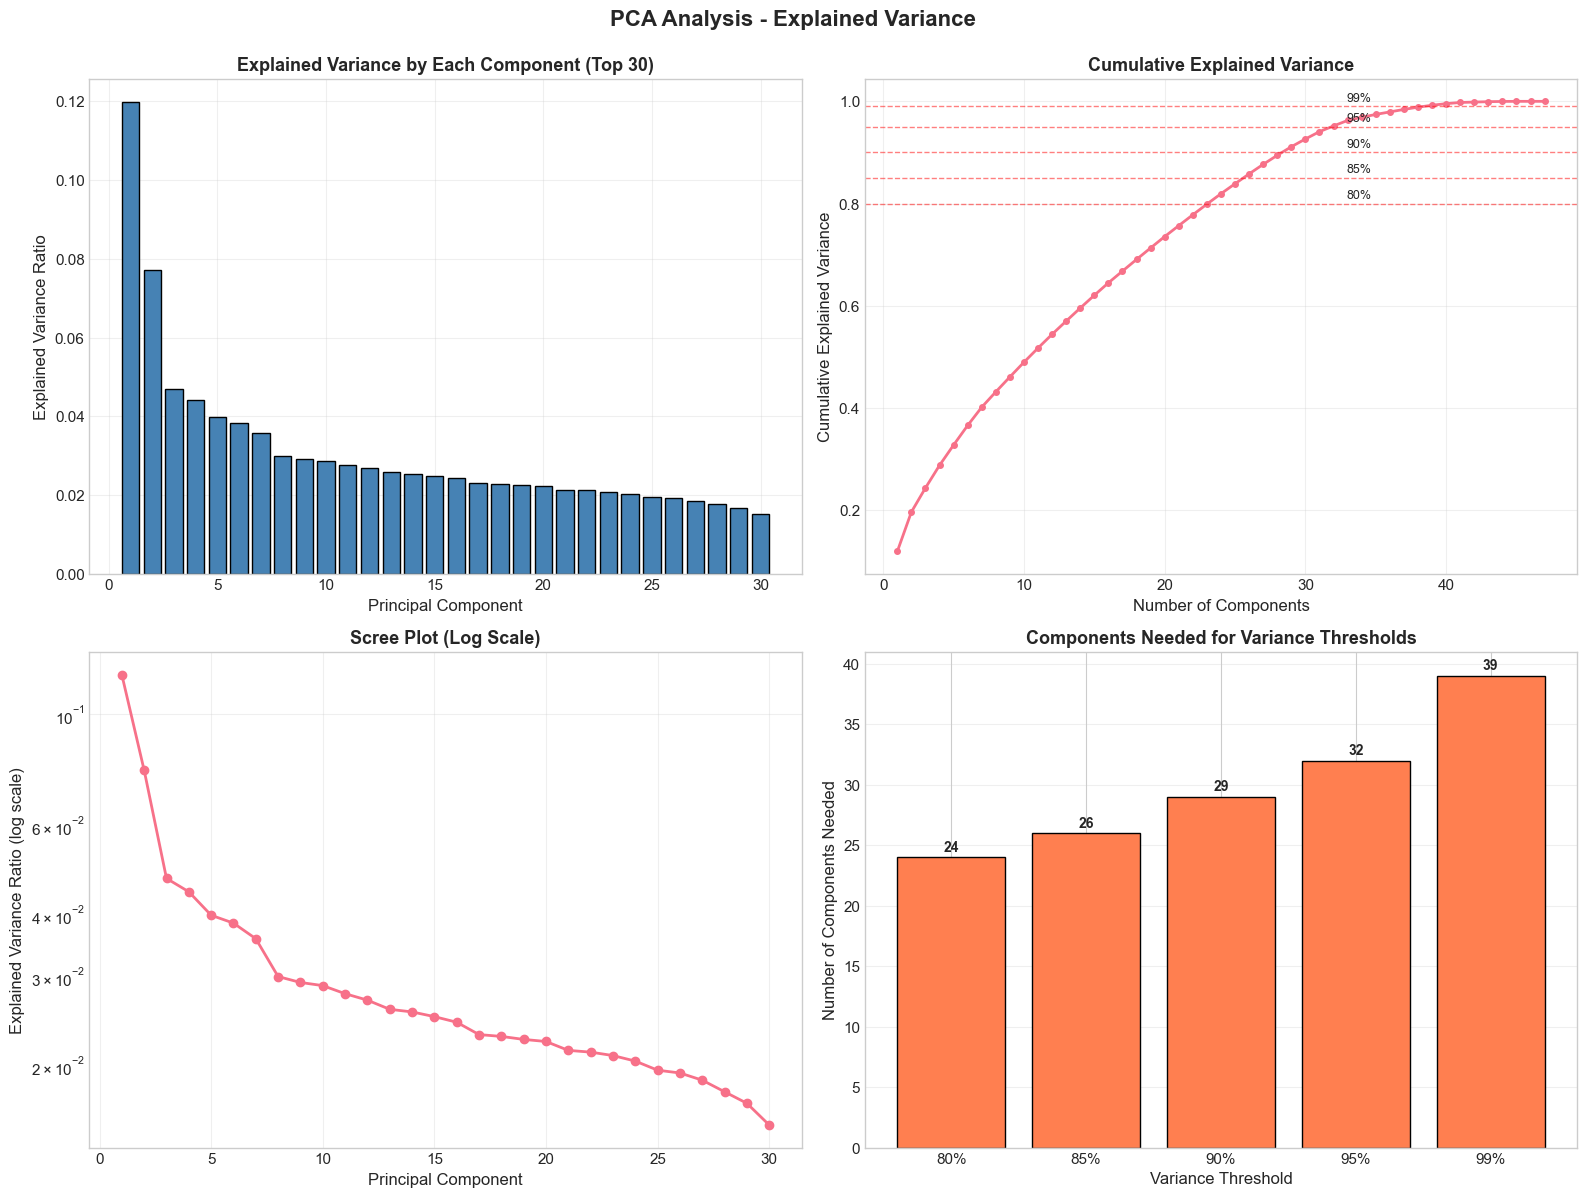


✓ PCA explained variance visualization saved!


In [4]:
# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X)

# Get explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for different variance thresholds
thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
components_needed = {}

for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    components_needed[threshold] = n_components
    print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

print(f"\nTotal variance explained by all components: {cumulative_variance[-1]:.4f}")

# Visualize explained variance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Individual explained variance (bar plot)
axes[0, 0].bar(range(1, min(31, len(explained_variance)+1)),
               explained_variance[:30],
               color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Principal Component', fontsize=12)
axes[0, 0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0, 0].set_title('Explained Variance by Each Component (Top 30)',
                      fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative explained variance
axes[0, 1].plot(range(1, len(cumulative_variance)+1),
                cumulative_variance,
                marker='o', linewidth=2, markersize=4)
for threshold in thresholds:
    axes[0, 1].axhline(y=threshold, color='red', linestyle='--',
                       linewidth=1, alpha=0.5)
    axes[0, 1].text(len(cumulative_variance)*0.7, threshold+0.01,
                    f'{threshold*100:.0f}%', fontsize=9)
axes[0, 1].set_xlabel('Number of Components', fontsize=12)
axes[0, 1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[0, 1].set_title('Cumulative Explained Variance',
                      fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scree plot (log scale)
axes[1, 0].plot(range(1, min(31, len(explained_variance)+1)),
                explained_variance[:30],
                marker='o', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Principal Component', fontsize=12)
axes[1, 0].set_ylabel('Explained Variance Ratio (log scale)', fontsize=12)
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Scree Plot (Log Scale)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Components needed for variance thresholds
axes[1, 1].bar(range(len(thresholds)),
               [components_needed[t] for t in thresholds],
               tick_label=[f'{t*100:.0f}%' for t in thresholds],
               color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Variance Threshold', fontsize=12)
axes[1, 1].set_ylabel('Number of Components Needed', fontsize=12)
axes[1, 1].set_title('Components Needed for Variance Thresholds',
                      fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (threshold, n_comp) in enumerate(components_needed.items()):
    axes[1, 1].text(i, n_comp + 0.5, str(n_comp),
                    ha='center', fontsize=10, fontweight='bold')

plt.suptitle('PCA Analysis - Explained Variance',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/pca_explained_variance.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PCA explained variance visualization saved!")

3.PCA Transformation - Multiple Configurations


In [6]:
# Transform with different number of components
pca_configs = {
    '2D': 2,
    '3D': 3,
    '85% variance': components_needed[0.85],
    '95% variance': components_needed[0.95],
    '1/3 original': X.shape[1] // 3
}

pca_results = {}

for name, n_components in pca_configs.items():
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)

    pca_results[name] = {
        'pca': pca,
        'X_transformed': X_transformed,
        'n_components': n_components,
        'variance_explained': pca.explained_variance_ratio_.sum()
    }

    print(f"\n{name}:")
    print(f"  Components: {n_components}")
    print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"  Shape: {X_transformed.shape}")

# Save PCA models
import joblib
for name, result in pca_results.items():
    filename = name.replace(' ', '_').replace('%', 'pct')
    joblib.dump(result['pca'], f'../results/models/pca_{filename}.pkl')
    print(f"✓ Saved: pca_{filename}.pkl")


2D:
  Components: 2
  Total variance explained: 0.1969
  Shape: (1470, 2)

3D:
  Components: 3
  Total variance explained: 0.2439
  Shape: (1470, 3)

85% variance:
  Components: 26
  Total variance explained: 0.8581
  Shape: (1470, 26)

95% variance:
  Components: 32
  Total variance explained: 0.9519
  Shape: (1470, 32)

1/3 original:
  Components: 15
  Total variance explained: 0.6197
  Shape: (1470, 15)
✓ Saved: pca_2D.pkl
✓ Saved: pca_3D.pkl
✓ Saved: pca_85pct_variance.pkl
✓ Saved: pca_95pct_variance.pkl
✓ Saved: pca_1/3_original.pkl


4.PCA 2D Visualization

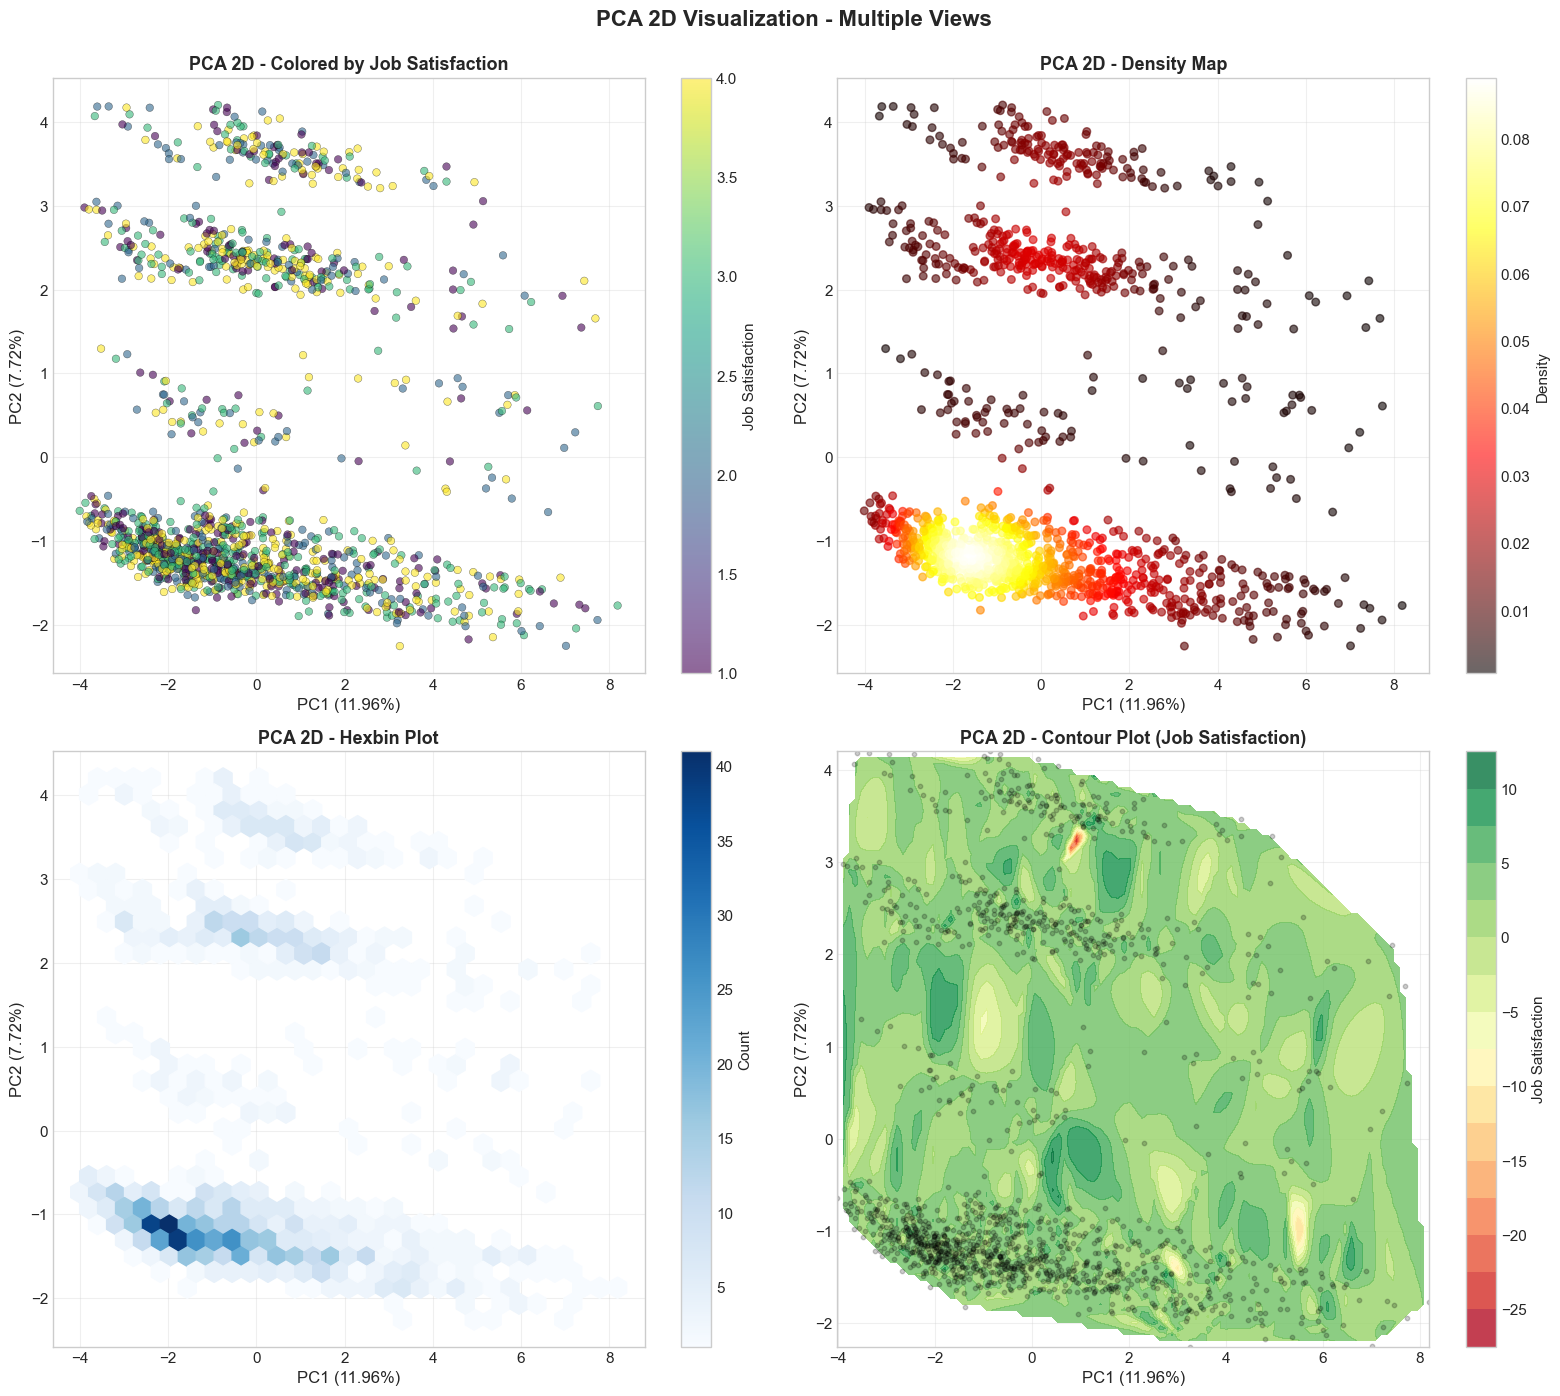


✓ PCA 2D visualization saved!


In [7]:
X_pca_2d = pca_results['2D']['X_transformed']

# Create comprehensive 2D visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Scatter plot colored by target
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=y, cmap='viridis', alpha=0.6, s=30, edgecolor='k', linewidth=0.3)
axes[0, 0].set_xlabel(f'PC1 ({pca_results["2D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({pca_results["2D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[0, 0].set_title('PCA 2D - Colored by Job Satisfaction', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Job Satisfaction', fontsize=11)

# 2. Density plot
from scipy.stats import gaussian_kde
xy = np.vstack([X_pca_2d[:, 0], X_pca_2d[:, 1]])
z = gaussian_kde(xy)(xy)
scatter2 = axes[0, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=z, cmap='hot', alpha=0.6, s=30)
axes[0, 1].set_xlabel(f'PC1 ({pca_results["2D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({pca_results["2D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[0, 1].set_title('PCA 2D - Density Map', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Density', fontsize=11)

# 3. Hexbin plot
hexbin = axes[1, 0].hexbin(X_pca_2d[:, 0], X_pca_2d[:, 1],
                            gridsize=30, cmap='Blues', mincnt=1)
axes[1, 0].set_xlabel(f'PC1 ({pca_results["2D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[1, 0].set_ylabel(f'PC2 ({pca_results["2D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[1, 0].set_title('PCA 2D - Hexbin Plot', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
cbar3 = plt.colorbar(hexbin, ax=axes[1, 0])
cbar3.set_label('Count', fontsize=11)

# 4. Contour plot
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[X_pca_2d[:, 0].min():X_pca_2d[:, 0].max():100j,
                           X_pca_2d[:, 1].min():X_pca_2d[:, 1].max():100j]
grid_z = griddata(X_pca_2d, y, (grid_x, grid_y), method='cubic')
contour = axes[1, 1].contourf(grid_x, grid_y, grid_z, levels=15, cmap='RdYlGn', alpha=0.8)
axes[1, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c='black', alpha=0.2, s=10)
axes[1, 1].set_xlabel(f'PC1 ({pca_results["2D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[1, 1].set_ylabel(f'PC2 ({pca_results["2D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[1, 1].set_title('PCA 2D - Contour Plot (Job Satisfaction)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
cbar4 = plt.colorbar(contour, ax=axes[1, 1])
cbar4.set_label('Job Satisfaction', fontsize=11)

plt.suptitle('PCA 2D Visualization - Multiple Views',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/pca_2d_visualization.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PCA 2D visualization saved!")

5.PCA Component Pairs Visualization

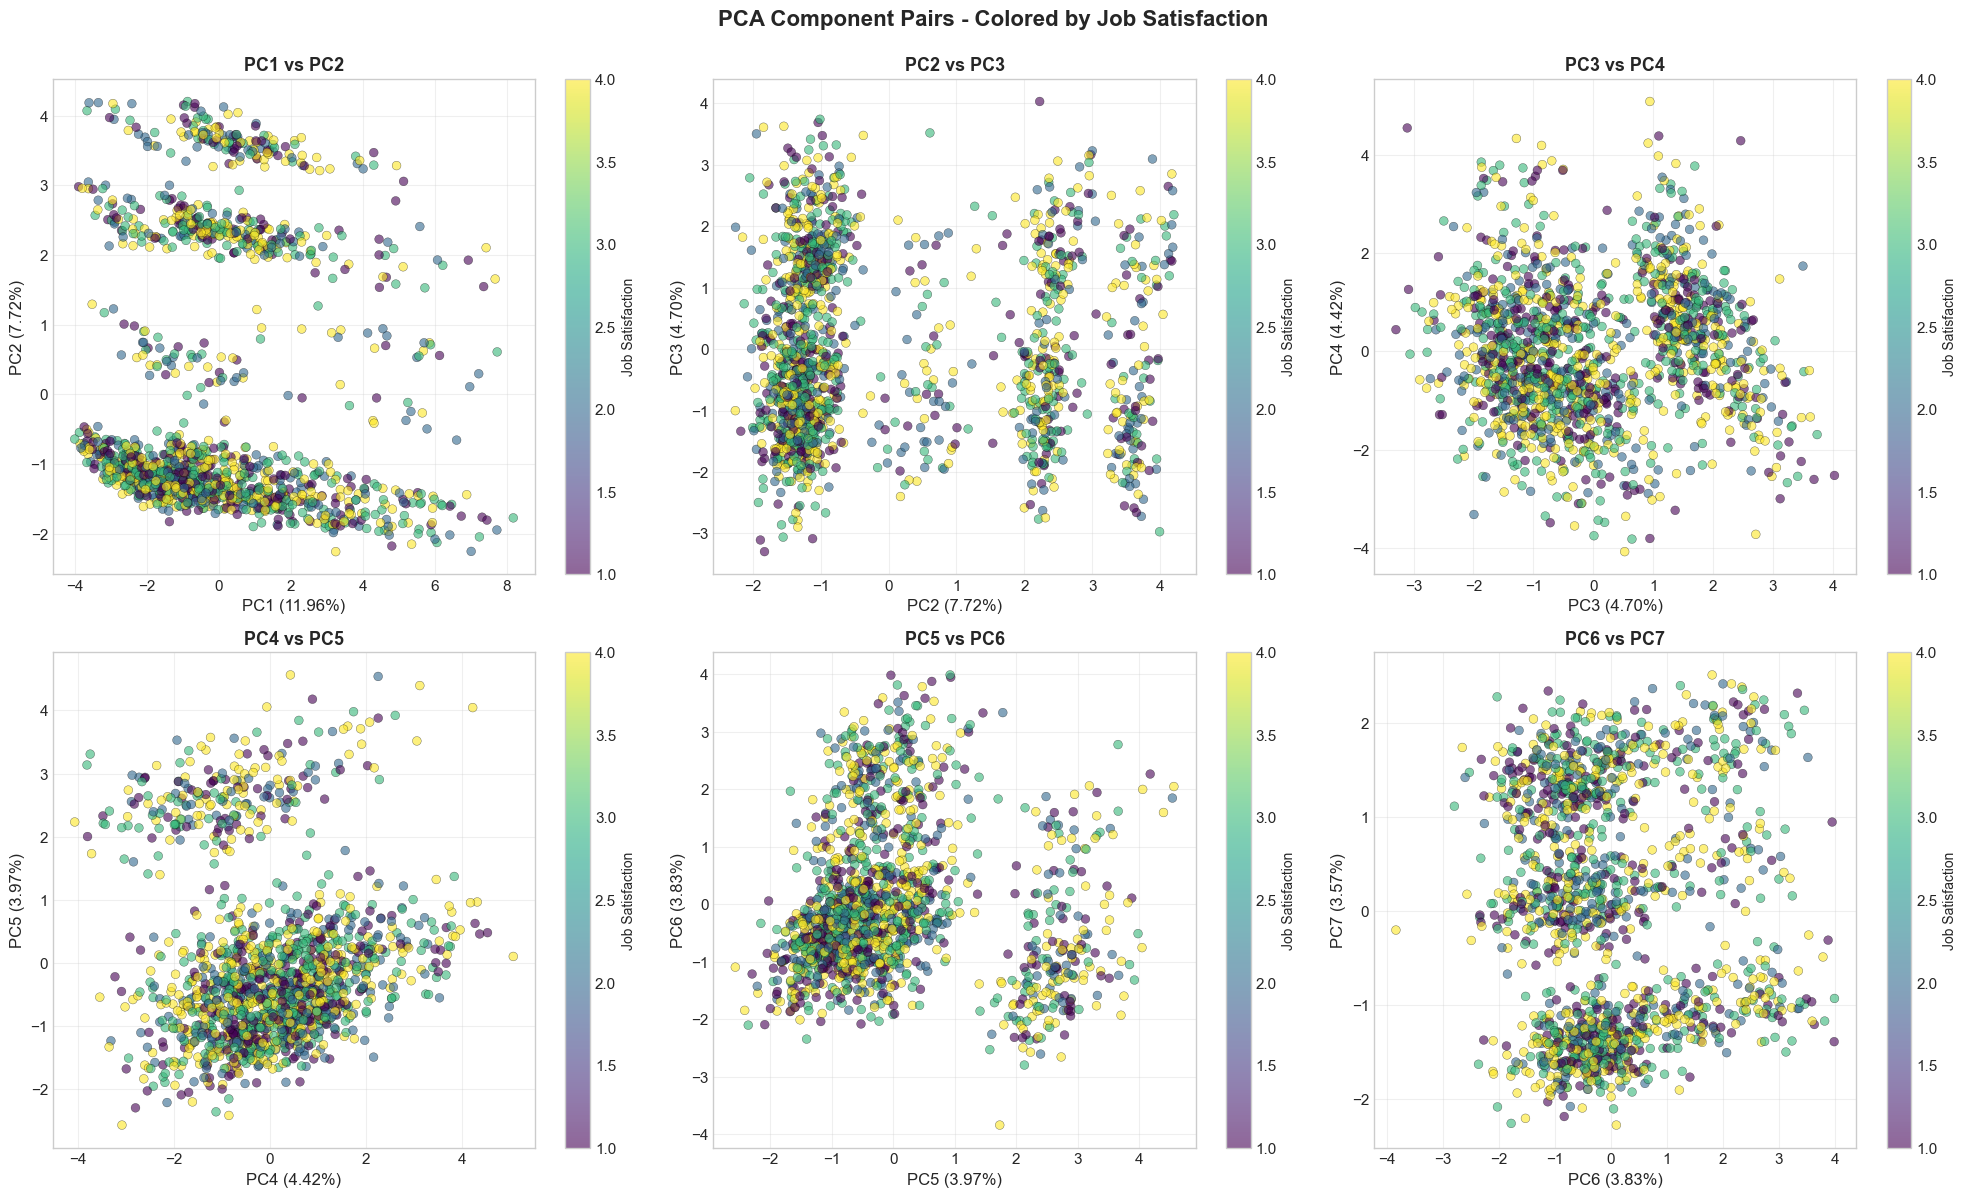


✓ PCA component pairs visualization saved!


In [8]:
# Use PCA with more components for pairwise analysis
n_pairs = 6
X_pca_multi = pca_results['95% variance']['X_transformed']

# Create pairwise plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i in range(min(n_pairs, X_pca_multi.shape[1] - 1)):
    pc1_idx = i
    pc2_idx = i + 1

    scatter = axes[i].scatter(X_pca_multi[:, pc1_idx], X_pca_multi[:, pc2_idx],
                              c=y, cmap='viridis', alpha=0.6, s=40,
                              edgecolor='k', linewidth=0.3)

    var1 = pca_results['95% variance']['pca'].explained_variance_ratio_[pc1_idx]
    var2 = pca_results['95% variance']['pca'].explained_variance_ratio_[pc2_idx]

    axes[i].set_xlabel(f'PC{pc1_idx+1} ({var1:.2%})', fontsize=12)
    axes[i].set_ylabel(f'PC{pc2_idx+1} ({var2:.2%})', fontsize=12)
    axes[i].set_title(f'PC{pc1_idx+1} vs PC{pc2_idx+1}', fontsize=13, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label('Job Satisfaction', fontsize=10)

plt.suptitle('PCA Component Pairs - Colored by Job Satisfaction',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/pca_component_pairs.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PCA component pairs visualization saved!")

6.PCA 3D Visualization

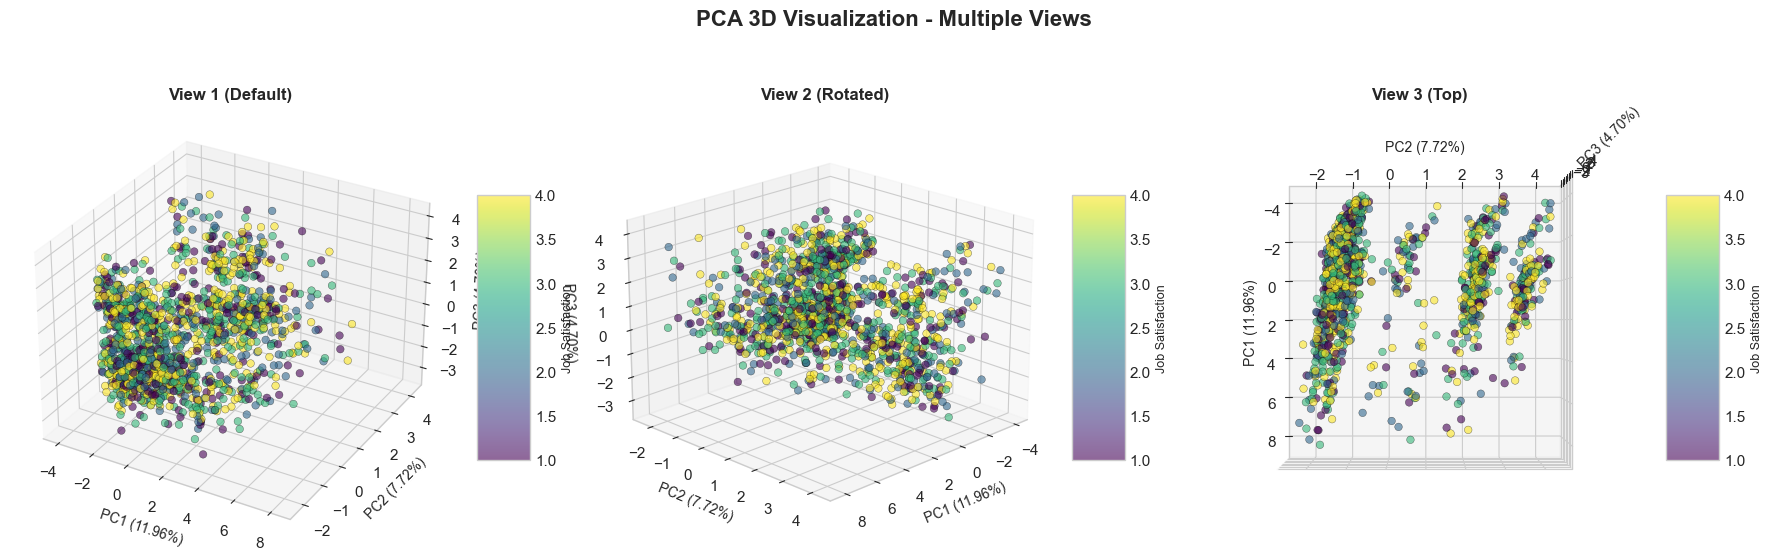


✓ PCA 3D visualization saved!


In [9]:
from mpl_toolkits.mplot3d import Axes3D

X_pca_3d = pca_results['3D']['X_transformed']

# Create 3D scatter plots
fig = plt.figure(figsize=(18, 6))

# View 1: Default view
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                       c=y, cmap='viridis', alpha=0.6, s=30, edgecolor='k', linewidth=0.3)
ax1.set_xlabel(f'PC1 ({pca_results["3D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=10)
ax1.set_ylabel(f'PC2 ({pca_results["3D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=10)
ax1.set_zlabel(f'PC3 ({pca_results["3D"]["pca"].explained_variance_ratio_[2]:.2%})', fontsize=10)
ax1.set_title('View 1 (Default)', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=5)
cbar1.set_label('Job Satisfaction', fontsize=9)

# View 2: Rotated view
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                       c=y, cmap='viridis', alpha=0.6, s=30, edgecolor='k', linewidth=0.3)
ax2.view_init(elev=20, azim=45)
ax2.set_xlabel(f'PC1 ({pca_results["3D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=10)
ax2.set_ylabel(f'PC2 ({pca_results["3D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=10)
ax2.set_zlabel(f'PC3 ({pca_results["3D"]["pca"].explained_variance_ratio_[2]:.2%})', fontsize=10)
ax2.set_title('View 2 (Rotated)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=5)
cbar2.set_label('Job Satisfaction', fontsize=9)

# View 3: Top view
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                       c=y, cmap='viridis', alpha=0.6, s=30, edgecolor='k', linewidth=0.3)
ax3.view_init(elev=90, azim=0)
ax3.set_xlabel(f'PC1 ({pca_results["3D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=10)
ax3.set_ylabel(f'PC2 ({pca_results["3D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=10)
ax3.set_zlabel(f'PC3 ({pca_results["3D"]["pca"].explained_variance_ratio_[2]:.2%})', fontsize=10)
ax3.set_title('View 3 (Top)', fontsize=12, fontweight='bold')
cbar3 = plt.colorbar(scatter3, ax=ax3, shrink=0.5, aspect=5)
cbar3.set_label('Job Satisfaction', fontsize=9)

plt.suptitle('PCA 3D Visualization - Multiple Views',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/pca_3d_visualization.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PCA 3D visualization saved!")

7.PCA Loadings Analysis


Top 5 features for each Principal Component:

PC1:
  JobLevel: 0.8791
  MonthlyIncome: 0.8651
  TotalWorkingYears: 0.8644
  YearsAtCompany: 0.7899
  YearsInCurrentRole: 0.6688

PC2:
  Department_Sales: 0.9455
  Department_Research & Development: 0.9311
  JobRole_Sales Executive: 0.8010
  EducationField_Marketing: 0.6535
  JobRole_Sales Representative: 0.3685

PC3:
  MaritalStatus_Single: 0.8382
  StockOptionLevel: 0.6805
  MaritalStatus_Married: 0.6667
  BusinessTravel_Travel_Frequently: 0.3054
  BusinessTravel_Travel_Rarely: 0.2936

PC4:
  NumCompaniesWorked: 0.4853
  YearsInCurrentRole: 0.4821
  YearsWithCurrManager: 0.4794
  YearsAtCompany: 0.3870
  YearsSinceLastPromotion: 0.3700

PC5:
  PercentSalaryHike: 0.8726
  PerformanceRating: 0.8607
  YearsWithCurrManager: 0.1711
  YearsInCurrentRole: 0.1531
  YearsAtCompany: 0.1495


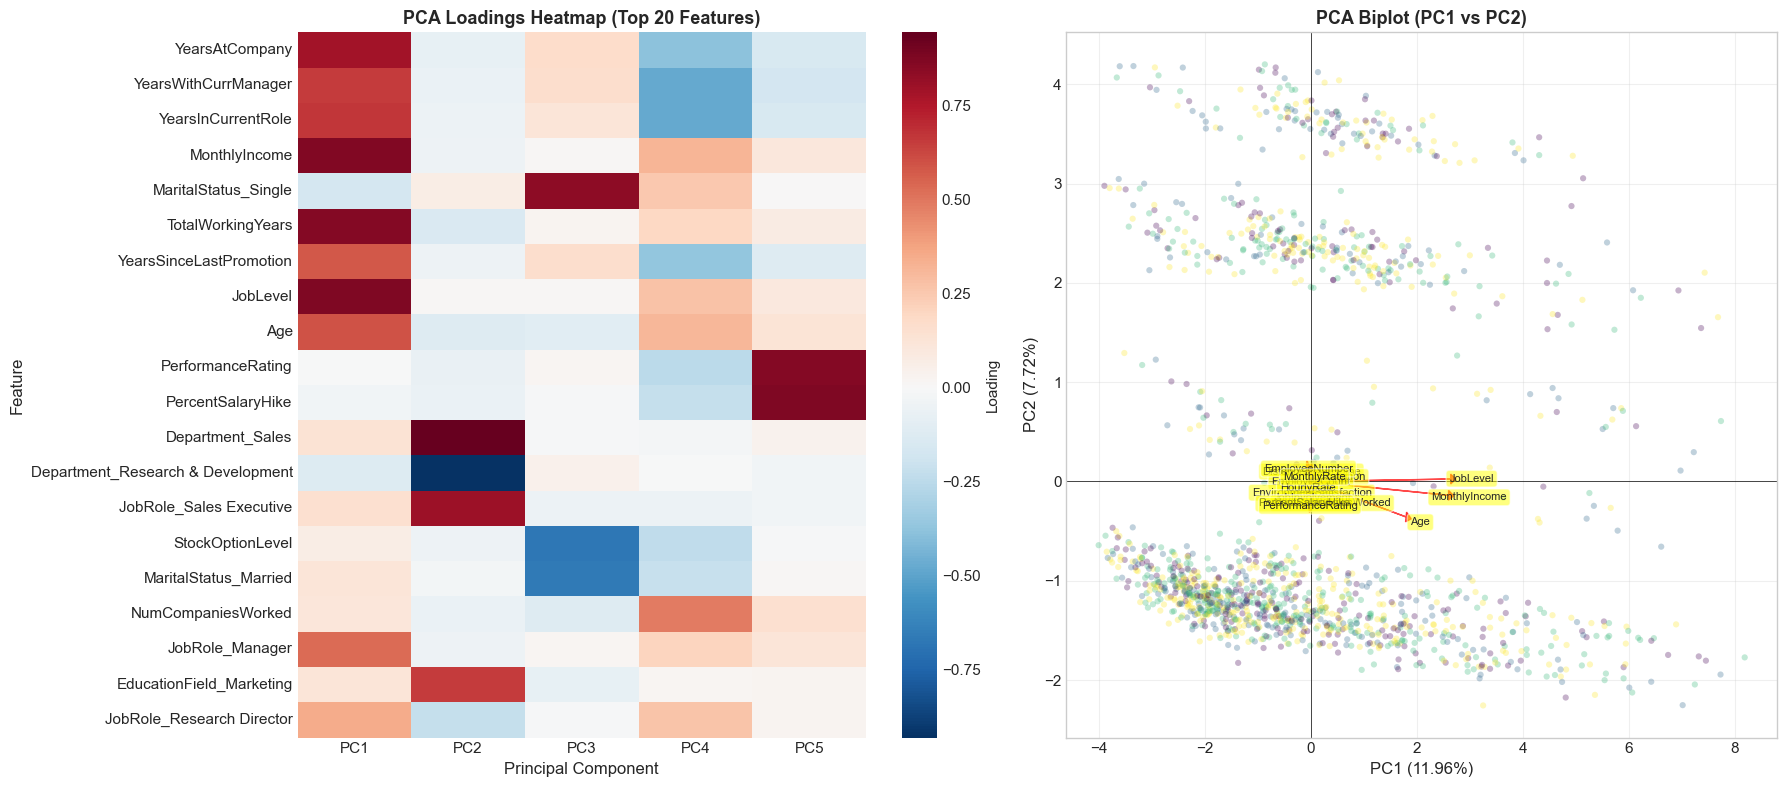


✓ PCA loadings visualization saved!


In [10]:
# Get loadings (components)
pca_model = pca_results['95% variance']['pca']
loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)

# Create loadings dataframe
loadings_df = pd.DataFrame(
    loadings[:, :5],  # Top 5 PCs
    columns=[f'PC{i+1}' for i in range(5)],
    index=feature_names
)

# Find top features for each PC
print("\nTop 5 features for each Principal Component:")
for pc in loadings_df.columns:
    print(f"\n{pc}:")
    top_features = loadings_df[pc].abs().sort_values(ascending=False).head(5)
    for feat, val in top_features.items():
        print(f"  {feat}: {val:.4f}")

# Visualize loadings
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Heatmap of loadings
top_n = 20
top_features_idx = loadings_df.abs().sum(axis=1).sort_values(ascending=False).head(top_n).index
loadings_top = loadings_df.loc[top_features_idx]

sns.heatmap(loadings_top, annot=False, cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Loading'}, ax=axes[0])
axes[0].set_title(f'PCA Loadings Heatmap (Top {top_n} Features)',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)

# Biplot for PC1 and PC2
ax = axes[1]
ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis',
           alpha=0.3, s=20, edgecolor='none')

# Plot loading vectors
scale_factor = 3
for i, feature in enumerate(feature_names[:15]):  # Top 15 features for clarity
    ax.arrow(0, 0, loadings[i, 0]*scale_factor, loadings[i, 1]*scale_factor,
             head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    ax.text(loadings[i, 0]*scale_factor*1.15, loadings[i, 1]*scale_factor*1.15,
            feature, fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

ax.set_xlabel(f'PC1 ({pca_results["2D"]["pca"].explained_variance_ratio_[0]:.2%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_results["2D"]["pca"].explained_variance_ratio_[1]:.2%})', fontsize=12)
ax.set_title('PCA Biplot (PC1 vs PC2)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/pca_loadings.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PCA loadings visualization saved!")

8.t-SNE Preparation and Parameter Selection

In [11]:
# For t-SNE, we'll use a sample if dataset is large
n_samples_tsne = min(2000, len(X))
print(f"Using {n_samples_tsne} samples for t-SNE (to manage computation time)")

# Sample indices
np.random.seed(42)
sample_idx = np.random.choice(len(X), n_samples_tsne, replace=False)
X_tsne_input = X[sample_idx]
y_tsne = y[sample_idx]

# Test different perplexity values
perplexity_values = [5, 30, 50]
tsne_results = {}

print("\nRunning t-SNE with different perplexity values...")
for perp in perplexity_values:
    print(f"\nPerplexity = {perp}")
    start_time = time.time()

    tsne = TSNE(n_components=2, perplexity=perp, random_state=42,
                n_iter=1000, verbose=0)
    X_tsne_transformed = tsne.fit_transform(X_tsne_input)

    elapsed = time.time() - start_time
    print(f"  Computation time: {elapsed:.2f} seconds")

    tsne_results[perp] = {
        'model': tsne,
        'X_transformed': X_tsne_transformed,
        'time': elapsed
    }

Using 1470 samples for t-SNE (to manage computation time)

Running t-SNE with different perplexity values...

Perplexity = 5
  Computation time: 3.23 seconds

Perplexity = 30
  Computation time: 3.58 seconds

Perplexity = 50
  Computation time: 4.17 seconds


9.t-SNE Visualization - Multiple Perplexities

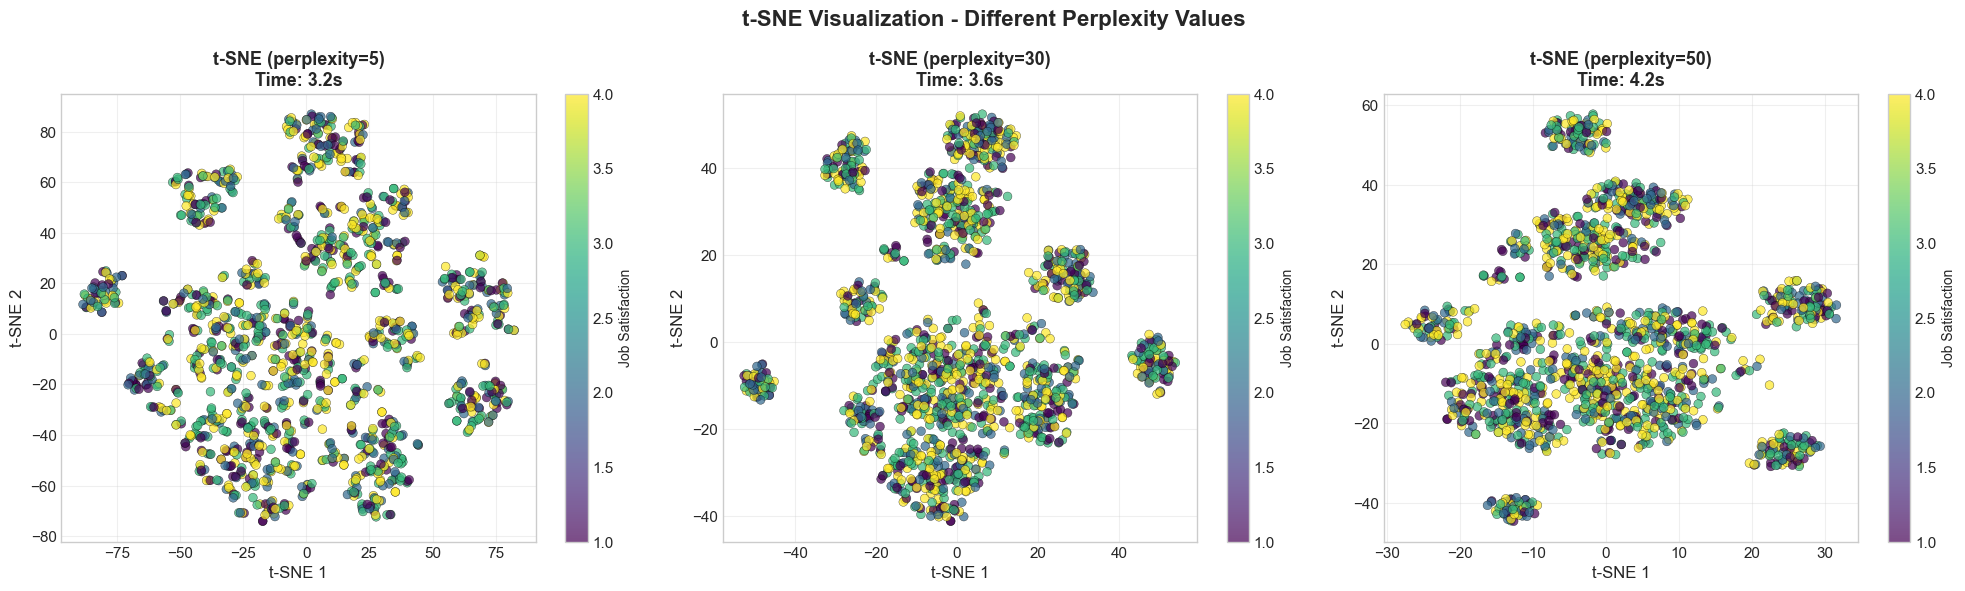


✓ t-SNE perplexity comparison saved!


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, perp in enumerate(perplexity_values):
    X_tsne = tsne_results[perp]['X_transformed']

    scatter = axes[idx].scatter(X_tsne[:, 0], X_tsne[:, 1],
                                c=y_tsne, cmap='viridis',
                                alpha=0.7, s=40, edgecolor='k', linewidth=0.3)
    axes[idx].set_xlabel('t-SNE 1', fontsize=12)
    axes[idx].set_ylabel('t-SNE 2', fontsize=12)
    axes[idx].set_title(f't-SNE (perplexity={perp})\nTime: {tsne_results[perp]["time"]:.1f}s',
                        fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter, ax=axes[idx])
    cbar.set_label('Job Satisfaction', fontsize=10)

plt.suptitle('t-SNE Visualization - Different Perplexity Values',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/tsne_perplexity_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ t-SNE perplexity comparison saved!")

10.t-SNE Detailed Visualization (Best Perplexity)

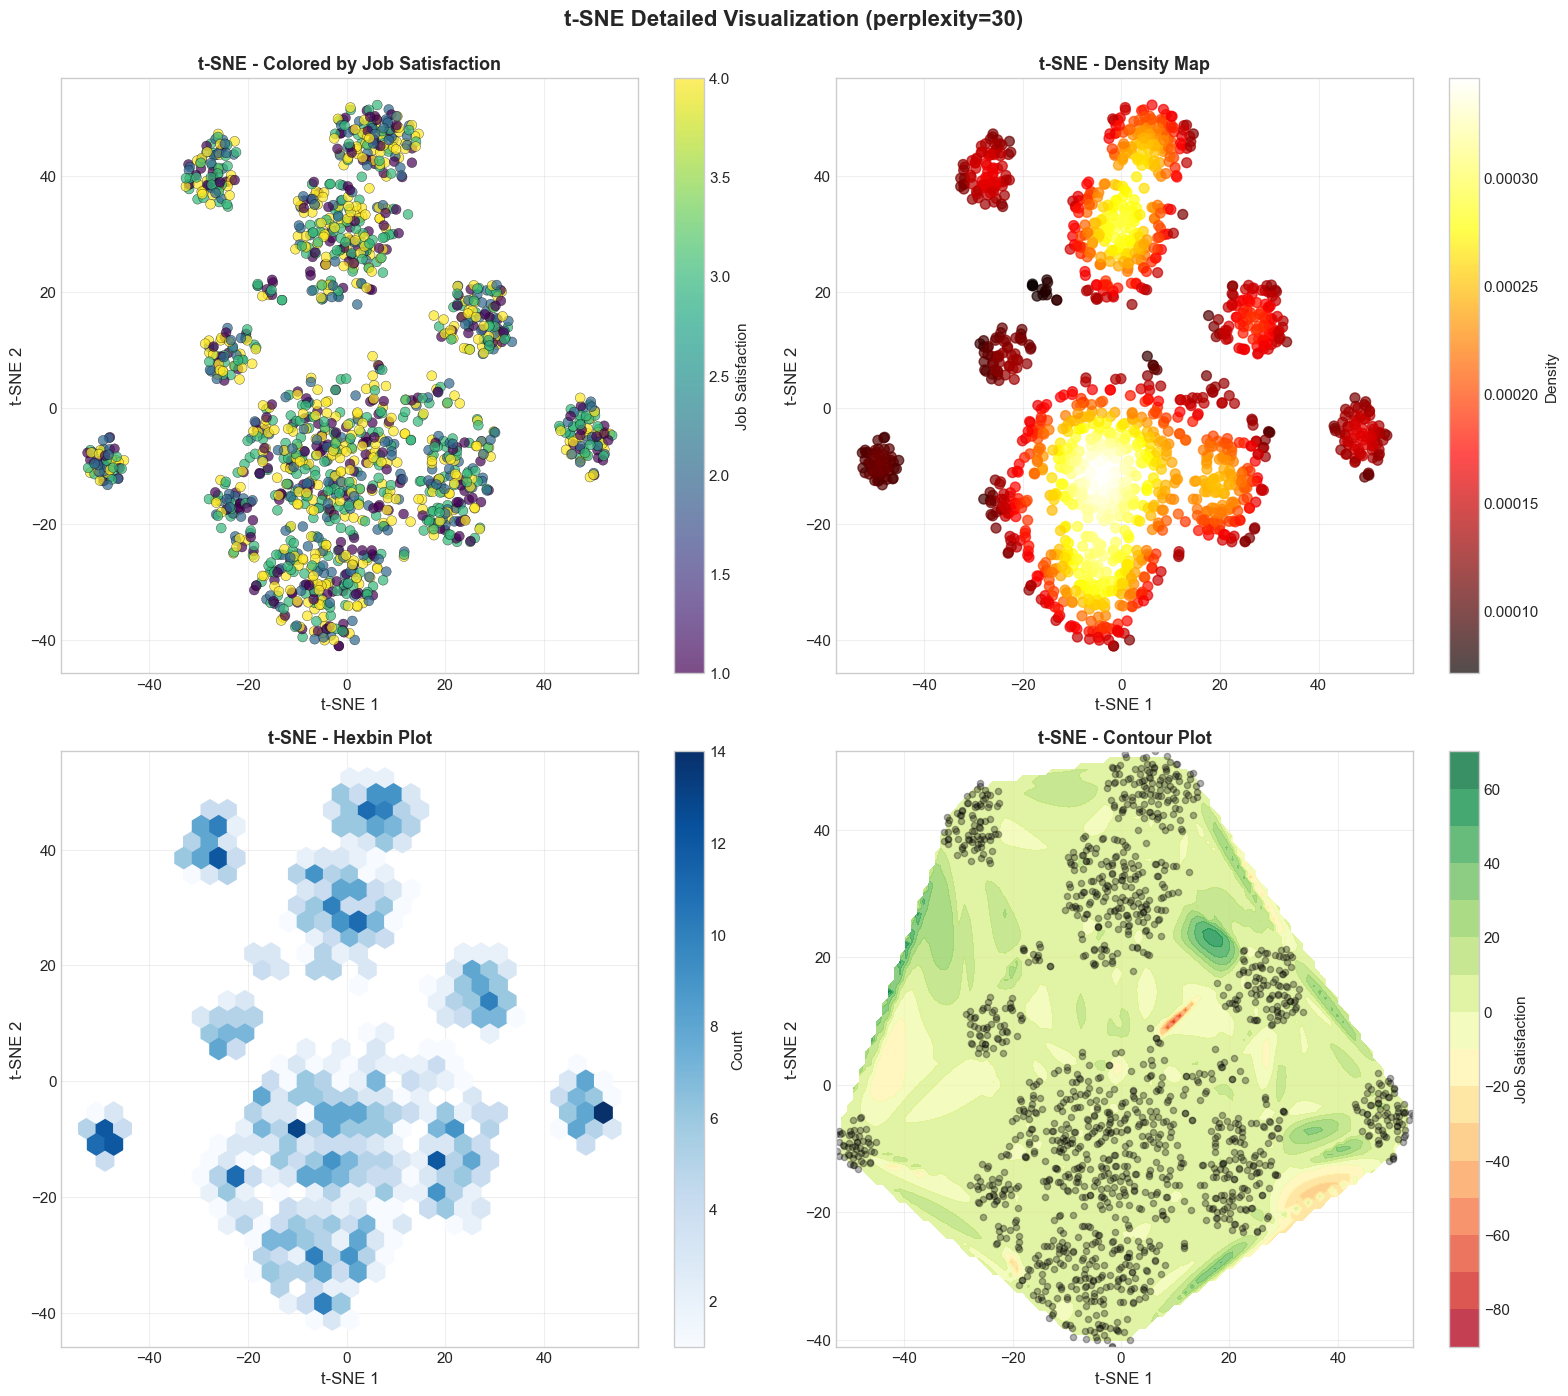


✓ t-SNE detailed visualization saved!


In [13]:
# Use perplexity=30 as it's often the default and works well
best_perp = 30
X_tsne_best = tsne_results[best_perp]['X_transformed']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Scatter colored by target
scatter1 = axes[0, 0].scatter(X_tsne_best[:, 0], X_tsne_best[:, 1],
                               c=y_tsne, cmap='viridis', alpha=0.7, s=50,
                               edgecolor='k', linewidth=0.3)
axes[0, 0].set_xlabel('t-SNE 1', fontsize=12)
axes[0, 0].set_ylabel('t-SNE 2', fontsize=12)
axes[0, 0].set_title(f't-SNE - Colored by Job Satisfaction',
                      fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Job Satisfaction', fontsize=11)

# 2. Density plot
xy = np.vstack([X_tsne_best[:, 0], X_tsne_best[:, 1]])
z = gaussian_kde(xy)(xy)
scatter2 = axes[0, 1].scatter(X_tsne_best[:, 0], X_tsne_best[:, 1],
                               c=z, cmap='hot', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1', fontsize=12)
axes[0, 1].set_ylabel('t-SNE 2', fontsize=12)
axes[0, 1].set_title('t-SNE - Density Map', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Density', fontsize=11)

# 3. Hexbin
hexbin = axes[1, 0].hexbin(X_tsne_best[:, 0], X_tsne_best[:, 1],
                            gridsize=30, cmap='Blues', mincnt=1)
axes[1, 0].set_xlabel('t-SNE 1', fontsize=12)
axes[1, 0].set_ylabel('t-SNE 2', fontsize=12)
axes[1, 0].set_title('t-SNE - Hexbin Plot', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
cbar3 = plt.colorbar(hexbin, ax=axes[1, 0])
cbar3.set_label('Count', fontsize=11)

# 4. Contour plot
grid_x, grid_y = np.mgrid[X_tsne_best[:, 0].min():X_tsne_best[:, 0].max():100j,
                           X_tsne_best[:, 1].min():X_tsne_best[:, 1].max():100j]
grid_z = griddata(X_tsne_best, y_tsne, (grid_x, grid_y), method='cubic')
contour = axes[1, 1].contourf(grid_x, grid_y, grid_z, levels=15, cmap='RdYlGn', alpha=0.8)
axes[1, 1].scatter(X_tsne_best[:, 0], X_tsne_best[:, 1], c='black', alpha=0.3, s=20)
axes[1, 1].set_xlabel('t-SNE 1', fontsize=12)
axes[1, 1].set_ylabel('t-SNE 2', fontsize=12)
axes[1, 1].set_title('t-SNE - Contour Plot', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
cbar4 = plt.colorbar(contour, ax=axes[1, 1])
cbar4.set_label('Job Satisfaction', fontsize=11)

plt.suptitle(f't-SNE Detailed Visualization (perplexity={best_perp})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/tsne_detailed.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ t-SNE detailed visualization saved!")

11.PCA vs t-SNE Comparison

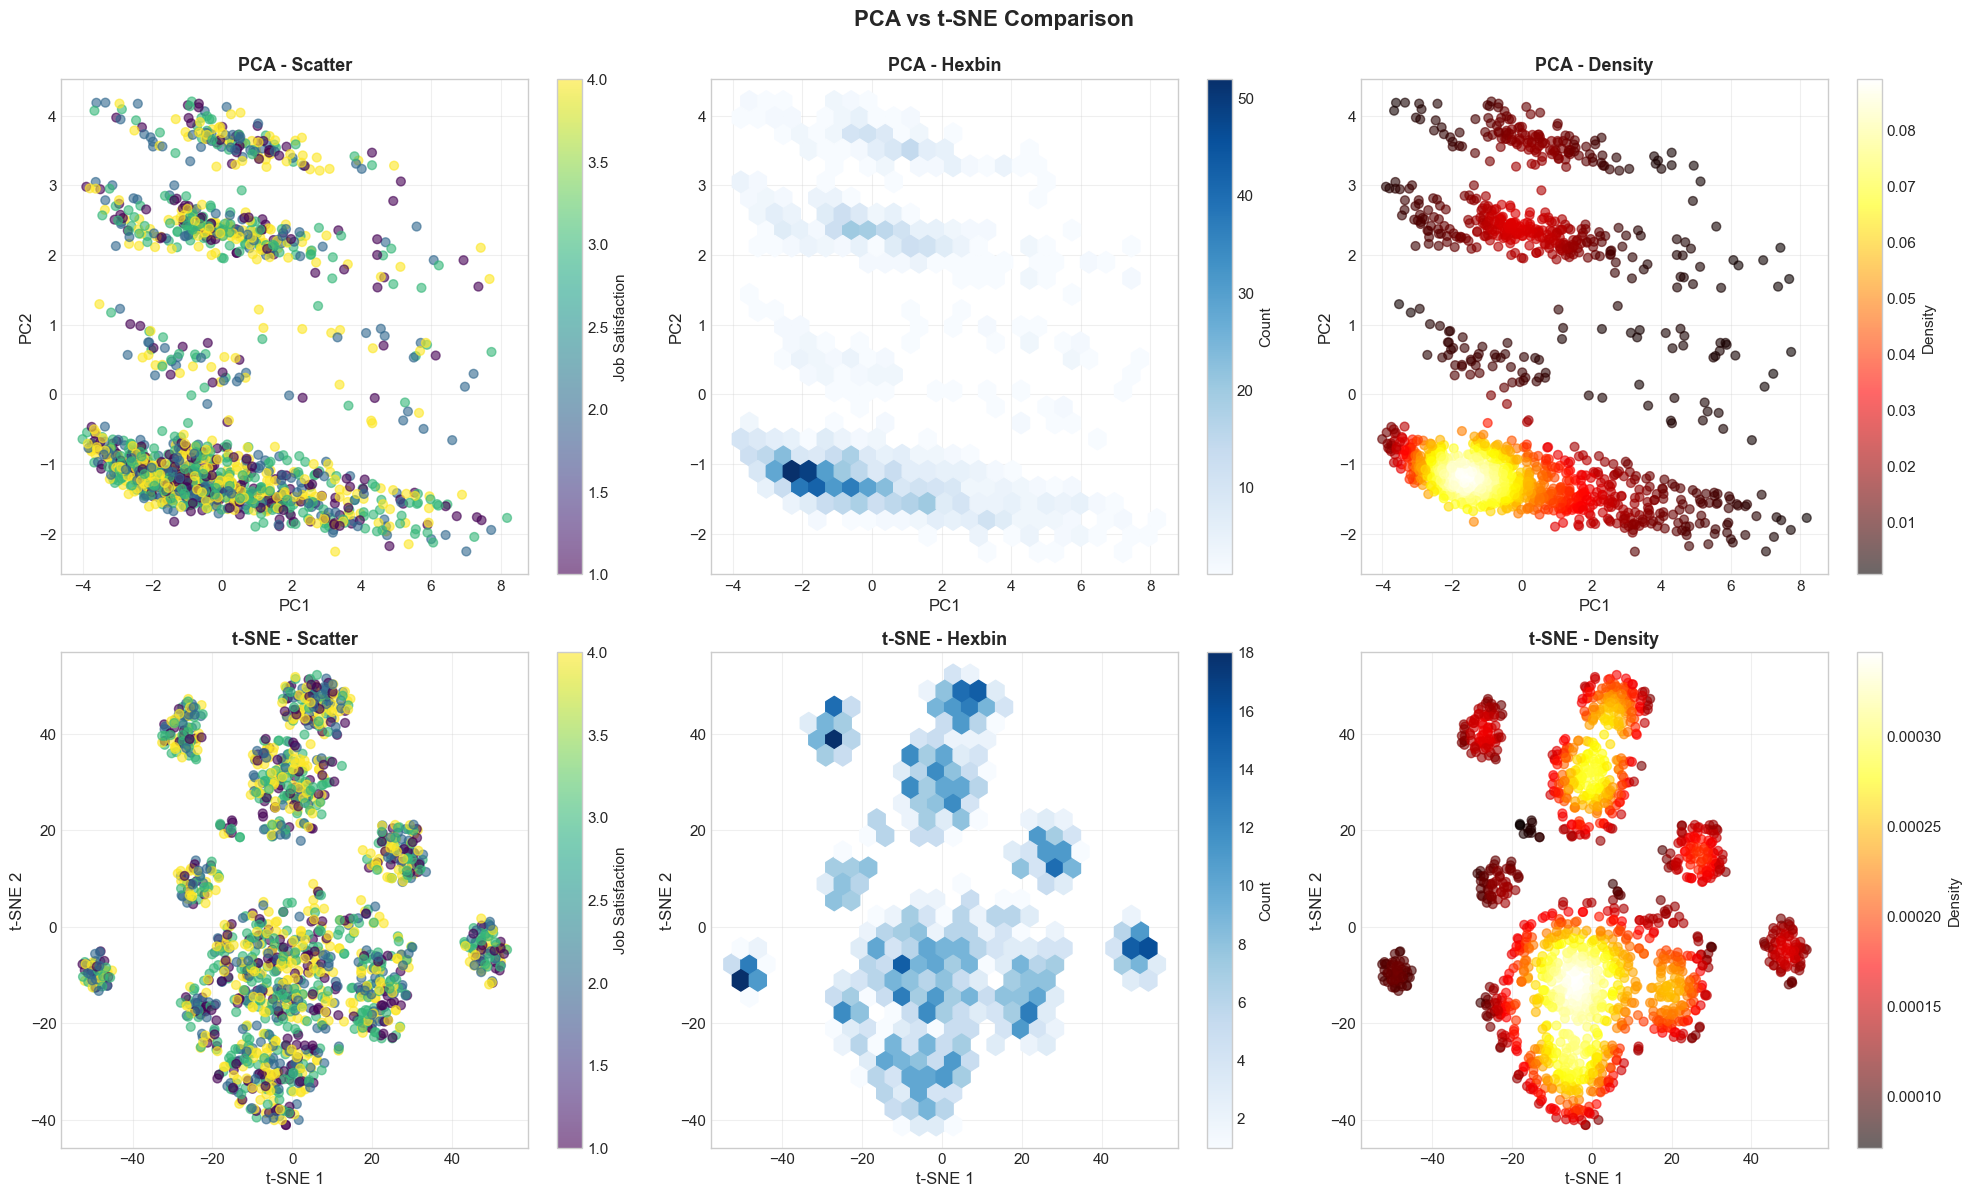


✓ PCA vs t-SNE comparison saved!


In [14]:
# Use same samples for fair comparison
X_pca_sample = X_pca_2d[sample_idx]
y_sample = y[sample_idx]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# PCA visualizations
scatter1 = axes[0, 0].scatter(X_pca_sample[:, 0], X_pca_sample[:, 1],
                               c=y_sample, cmap='viridis', alpha=0.6, s=40)
axes[0, 0].set_xlabel('PC1', fontsize=12)
axes[0, 0].set_ylabel('PC2', fontsize=12)
axes[0, 0].set_title('PCA - Scatter', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Job Satisfaction')

hexbin1 = axes[0, 1].hexbin(X_pca_sample[:, 0], X_pca_sample[:, 1],
                              gridsize=25, cmap='Blues', mincnt=1)
axes[0, 1].set_xlabel('PC1', fontsize=12)
axes[0, 1].set_ylabel('PC2', fontsize=12)
axes[0, 1].set_title('PCA - Hexbin', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(hexbin1, ax=axes[0, 1], label='Count')

xy_pca = np.vstack([X_pca_sample[:, 0], X_pca_sample[:, 1]])
z_pca = gaussian_kde(xy_pca)(xy_pca)
scatter3 = axes[0, 2].scatter(X_pca_sample[:, 0], X_pca_sample[:, 1],
                               c=z_pca, cmap='hot', alpha=0.6, s=40)
axes[0, 2].set_xlabel('PC1', fontsize=12)
axes[0, 2].set_ylabel('PC2', fontsize=12)
axes[0, 2].set_title('PCA - Density', fontsize=13, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Density')

# t-SNE visualizations
scatter4 = axes[1, 0].scatter(X_tsne_best[:, 0], X_tsne_best[:, 1],
                               c=y_tsne, cmap='viridis', alpha=0.6, s=40)
axes[1, 0].set_xlabel('t-SNE 1', fontsize=12)
axes[1, 0].set_ylabel('t-SNE 2', fontsize=12)
axes[1, 0].set_title('t-SNE - Scatter', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Job Satisfaction')

hexbin2 = axes[1, 1].hexbin(X_tsne_best[:, 0], X_tsne_best[:, 1],
                              gridsize=25, cmap='Blues', mincnt=1)
axes[1, 1].set_xlabel('t-SNE 1', fontsize=12)
axes[1, 1].set_ylabel('t-SNE 2', fontsize=12)
axes[1, 1].set_title('t-SNE - Hexbin', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(hexbin2, ax=axes[1, 1], label='Count')

xy_tsne = np.vstack([X_tsne_best[:, 0], X_tsne_best[:, 1]])
z_tsne = gaussian_kde(xy_tsne)(xy_tsne)
scatter6 = axes[1, 2].scatter(X_tsne_best[:, 0], X_tsne_best[:, 1],
                               c=z_tsne, cmap='hot', alpha=0.6, s=40)
axes[1, 2].set_xlabel('t-SNE 1', fontsize=12)
axes[1, 2].set_ylabel('t-SNE 2', fontsize=12)
axes[1, 2].set_title('t-SNE - Density', fontsize=13, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter6, ax=axes[1, 2], label='Density')

plt.suptitle('PCA vs t-SNE Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/dimensionality_reduction/pca_vs_tsne_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ PCA vs t-SNE comparison saved!")

12.Summary Statistics and Comparison

In [17]:
summary_data = []

# PCA summary
for name, result in pca_results.items():
    summary_data.append({
        'Method': f'PCA ({name})',
        'Components': result['n_components'],
        'Variance Explained': f"{result['variance_explained']:.4f}",
        'Output Shape': str(result['X_transformed'].shape),
        'Computation Time': 'Fast (<1s)'
    })

# t-SNE summary
for perp, result in tsne_results.items():
    summary_data.append({
        'Method': f't-SNE (perp={perp})',
        'Components': 2,
        'Variance Explained': 'N/A',
        'Output Shape': str(result['X_transformed'].shape),
        'Computation Time': f"{result['time']:.1f}s"
    })

summary_df = pd.DataFrame(summary_data)
print("\nDimensionality Reduction Methods Summary:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../results/metrics/dimensionality_reduction_summary.csv', index=False)
print("\n✓ Summary saved to CSV")


Dimensionality Reduction Methods Summary:
            Method  Components Variance Explained Output Shape Computation Time
          PCA (2D)           2             0.1969    (1470, 2)       Fast (<1s)
          PCA (3D)           3             0.2439    (1470, 3)       Fast (<1s)
PCA (85% variance)          26             0.8581   (1470, 26)       Fast (<1s)
PCA (95% variance)          32             0.9519   (1470, 32)       Fast (<1s)
PCA (1/3 original)          15             0.6197   (1470, 15)       Fast (<1s)
    t-SNE (perp=5)           2                N/A    (1470, 2)             3.2s
   t-SNE (perp=30)           2                N/A    (1470, 2)             3.6s
   t-SNE (perp=50)           2                N/A    (1470, 2)             4.2s

✓ Summary saved to CSV


13.Export Transformed Data

In [19]:
# Save PCA transformed data (different configurations)
for name, result in pca_results.items():
    filename = name.replace(' ', '_').replace('%', 'pct')
    X_transformed = result['X_transformed']

    # Create DataFrame
    col_names = [f'PC{i+1}' for i in range(X_transformed.shape[1])]
    df_transformed = pd.DataFrame(X_transformed, columns=col_names)
    df_transformed[target_col] = y

    # Save
    df_transformed.to_csv(f'../data/processed/pca_{filename}.csv', index=False)
    print(f"✓ Saved: pca_{filename}.csv")

# Save best t-SNE result
df_tsne = pd.DataFrame(X_tsne_best, columns=['tSNE1', 'tSNE2'])
df_tsne[target_col] = y_tsne
df_tsne.to_csv('../data/processed/tsne_2d.csv', index=False)
print("✓ Saved: tsne_2d.csv")

✓ Saved: pca_2D.csv
✓ Saved: pca_3D.csv
✓ Saved: pca_85pct_variance.csv
✓ Saved: pca_95pct_variance.csv
✓ Saved: pca_1/3_original.csv
✓ Saved: tsne_2d.csv


14.Comparison Report

In [21]:
comparison_report = f"""
{'='*70}
DIMENSIONALITY REDUCTION COMPARISON REPORT
{'='*70}

1. PRINCIPAL COMPONENT ANALYSIS (PCA)

   Advantages:
   ✓ Linear transformation - preserves global structure
   ✓ Fast computation
   ✓ Deterministic (same results every run)
   ✓ Captures maximum variance
   ✓ Can explain variance ratios

   Results:
   - 2D: {pca_results['2D']['variance_explained']:.2%} variance explained
   - 3D: {pca_results['3D']['variance_explained']:.2%} variance explained
   - 85% variance: {pca_results['85% variance']['n_components']} components
   - 95% variance: {pca_results['95% variance']['n_components']} components
   - 1/3 original: {pca_results['1/3 original']['n_components']} components ({pca_results['1/3 original']['variance_explained']:.2%} variance)

   Interpretation:
   - PC1 captures {pca_results['2D']['pca'].explained_variance_ratio_[0]:.2%} of variance
   - PC2 captures {pca_results['2D']['pca'].explained_variance_ratio_[1]:.2%} of variance
   - Top {pca_results['95% variance']['n_components']} components capture 95% of information

2. t-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING (t-SNE)

   Advantages:
   ✓ Non-linear transformation - captures local structure
   ✓ Excellent for visualization and cluster discovery
   ✓ Preserves local neighborhoods

   Disadvantages:
   ✗ Slower computation
   ✗ Non-deterministic (different runs give different results)
   ✗ Cannot explain variance
   ✗ Perplexity parameter needs tuning

   Results tested:
   - Perplexity 5: {tsne_results[5]['time']:.1f}s
   - Perplexity 30: {tsne_results[30]['time']:.1f}s (recommended)
   - Perplexity 50: {tsne_results[50]['time']:.1f}s

3. COMPARISON & RECOMMENDATIONS

   Use PCA when:
   • Need to reduce dimensions for ML models
   • Want to understand variance contribution
   • Need fast, reproducible results
   • Linear relationships are important
   • Need more than 2-3 dimensions

   Use t-SNE when:
   • Focus on visualization only
   • Want to discover clusters/patterns
   • Local structure is important
   • 2D/3D visualization is the goal

   For this project:
   • Use PCA with {pca_results['1/3 original']['n_components']} components for modeling (captures {pca_results['1/3 original']['variance_explained']:.2%} variance)
   • Use t-SNE for exploratory visualization
   • Both methods show similar clustering patterns

{'='*70}
Analysis completed: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""

print(comparison_report)
print("\n" + "="*70)
print("✓ DIMENSIONALITY REDUCTION COMPLETE!")
print("="*70)
print("\nKey Outputs:")
print(f"1. PCA models saved for {len(pca_results)} configurations")
print(f"2. Transformed datasets exported")
print(f"3. Comprehensive visualizations created")
print(f"4. Summary and comparison reports generated")
print("\nNext: Run 04_Clustering.ipynb")
print("="*70)


DIMENSIONALITY REDUCTION COMPARISON REPORT

1. PRINCIPAL COMPONENT ANALYSIS (PCA)

   Advantages:
   ✓ Linear transformation - preserves global structure
   ✓ Fast computation
   ✓ Deterministic (same results every run)
   ✓ Captures maximum variance
   ✓ Can explain variance ratios

   Results:
   - 2D: 19.69% variance explained
   - 3D: 24.39% variance explained
   - 85% variance: 26 components
   - 95% variance: 32 components
   - 1/3 original: 15 components (61.97% variance)

   Interpretation:
   - PC1 captures 11.96% of variance
   - PC2 captures 7.72% of variance
   - Top 32 components capture 95% of information

2. t-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING (t-SNE)

   Advantages:
   ✓ Non-linear transformation - captures local structure
   ✓ Excellent for visualization and cluster discovery
   ✓ Preserves local neighborhoods

   Disadvantages:
   ✗ Slower computation
   ✗ Non-deterministic (different runs give different results)
   ✗ Cannot explain variance
   ✗ Perplexity p